In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.7 MB/s 
     |████████████████████████████████| 7.6 MB 58.6 MB/s 
     |████████████████████████████████| 182 kB 81.5 MB/s 


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.0 MB/s 


In [ ]:
!pip3 install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 13.6 MB/s 
     |████████████████████████████████| 213 kB 76.7 MB/s 
     |████████████████████████████████| 132 kB 62.6 MB/s 
     |████████████████████████████████| 127 kB 69.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


<h2>Training</h2>
<h4>Importer les packages nécessaire :</h4>

In [ ]:

from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

#from datasets import load_dataset, Dataset, DatasetDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datasets import Dataset, DatasetDict


In [ ]:
#from transformers import AutoTokenizer
#model = 'microsoft/deberta-v3-small'
#tokz = AutoTok  enizer.from_pretrained(model)

In [ ]:
df_train=pd.read_csv('train.csv')

#df.drop('section', inplace=True, axis=1)
#df.drop('inputs', inplace=True, axis=1)

In [ ]:
df_train

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [ ]:
df_test=pd.read_csv('test.csv')

print("len = ",len(df_test))
df_test.head()

len =  36


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [ ]:
df_train.target.value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

In [ ]:
df_train.anchor.value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

In [ ]:
df_train.context.value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

In [ ]:
df_train['section'] = df_train.context.str[0]
df_train.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

Nous allons Afficher un histogramme des scores :

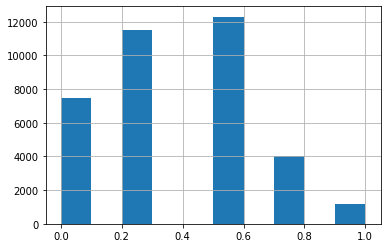

In [ ]:
df_train.score.hist()

<h4>Il y a un petit nombre qui sont notés 1.0 - voici un échantillon :</h4>

In [ ]:
df_train[df_train.score==1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


<h4>J'ai essayé de trouver un modèle , mais avec une précision raisonnable. J'ai trouvé que deberta-v3-small correspond à la facture</h4>

In [ ]:
model = 'microsoft/deberta-v3-small'
#model = 'microsoft/deberta-v3-large'

<h4>Nous pouvons maintenant créer un tokenizer pour ce modèle. Notez que les modèles pré-entraînés . Afin de vous assurer que votre tokenizer correspond à votre modèle, pour ca en utilisez l'AutoTokenizer, en transmettant le nom de votre modèle</h4>

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

tokz = AutoTokenizer.from_pretrained(model)

Loading BERT tokenizer...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<h4>Nous devrons combiner context, anchor, et target d'une manière ou d'une autre. Pour commencer, nous allons simplement les combiner tous en une seule chaîne. Le modèle devra savoir où commence chaque section, nous pouvons donc utiliser le jeton de séparation spécial pour le dire :</h4>

In [ ]:
sep = tokz.sep_token
sep

'[SEP]'

Créons maintenant notre colonne combinée :

In [ ]:
df_train['inputs'] = df_train.context + sep + df_train.anchor + sep + df_train.target

In [ ]:
df_train['inputs'][0]

'A47[SEP]abatement[SEP]abatement of pollution'

<h4>
En règle générale, nous obtiendrons les meilleures performances si nous convertissons les pandas DataFrames en ensembles de données HuggingFace, nous les convertirons donc et renommerons également la colonne de score en ce que Transformers attend pour la variable dépendante, qui est label :</h4>

In [ ]:
ds = Dataset.from_pandas(df_train).rename_column('score', 'label')
test_ds = Dataset.from_pandas(df_test)

In [ ]:
test_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context'],
    num_rows: 36
})

<h4>Pour tokeniser les données, nous allons créer une fonction (puisque c'est ce dont Dataset.map aura besoin) :</h4>

In [ ]:
def tok_func(x): return tokz(x["inputs"])

In [ ]:
dt='which makes the spatial information directly applied to much deeper layers and a more accurate segmentation resul'

tokz(dt)

{'input_ids': [1, 319, 682, 262, 10951, 439, 1372, 2312, 264, 400, 4447, 4974, 263, 266, 310, 3027, 27160, 961, 45106, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
#Exemple :
# Print the original sentence.
print(' Original: ', dt)

# Print the sentence split into tokens.
print('Tokenized: ', tokz.tokenize(dt))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokz.convert_tokens_to_ids(tokz.tokenize(df_train.inputs[0])))

 Original:  which makes the spatial information directly applied to much deeper layers and a more accurate segmentation resul
Tokenized:  ['▁which', '▁makes', '▁the', '▁spatial', '▁information', '▁directly', '▁applied', '▁to', '▁much', '▁deeper', '▁layers', '▁and', '▁a', '▁more', '▁accurate', '▁segmentation', '▁re', 'sul']
Token IDs:  [336, 5753, 2, 47284, 2, 47284, 265, 6435]


<h4>Essayons un exemple de dataset :</h4>

In [ ]:
ds[0]

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'label': 0.5,
 'section': 'A',
 'inputs': 'A47[SEP]abatement[SEP]abatement of pollution'}

In [ ]:
tok_func(ds[0])

{'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokz.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

<h4>Nous pouvons maintenant tokeniser l'entrée. Nous allons utiliser le traitement par lots pour l'accélérer et supprimer les colonnes dont nous n'avons plus besoin :</h4>

In [ ]:
inps = "anchor","target","context"

In [ ]:
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section')) # supprimer les colonnes "anchor","target","context" ,'inputs','id','section'

  0%|          | 0/37 [00:00<?, ?ba/s]

In [ ]:
tok_ds

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [ ]:
#list(tok_ds)

In [ ]:
type(tok_ds)

datasets.arrow_dataset.Dataset

on va diviser dataset a 20 %pour le  test et 80% pour  l'entrainement apres l'éxtraction de vecteur caractériqtique 

In [ ]:
dds = tok_ds.train_test_split(0.20, seed=0)

In [ ]:
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 29178
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7295
    })
})

Et apres on diviser 80% a deux partie de validation et l'entrainement

In [ ]:
train_ds = dds['train'].train_test_split(0.20, seed=0)

In [ ]:
#val_anchors

pour afficher la métrique d'évaluation du modèle

In [ ]:
#def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}    # to display model evaluation mitrex Preson(the degree of similarity between two sentences)
import datasets
matric = datasets.load_metric("glue","mrpc")

def compute_metrics(eval_pred):   #to display model evaluation mitrex accuracy
  predictions, labels = eval_pred
  predictions = predictions.reshape(len(predictions))
    #predictions = np.argmax(predictions,axis = -1)
  return  matric.compute(predictions=predictions,references=labels)

<ipython-input-70-2025373563d0>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  matric = datasets.load_metric("glue","mrpc")


préparer les argument de module , les meilleur model

In [ ]:
lr,bs = 8e-5,128 
epochs = 4 

In [ ]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs,
    num_train_epochs=epochs, report_to='none')

on va passer notre modele le modéle pré entraîné 'microsoft/deberta-v3-small' qui déja telecharger et les étiquete

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=1)

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

et finalement passer les jeux de données d'entrainement ,  les jeux de données  d'évalution et les argument , tokenizer qui utilisé  et le mitric d'evalution a notre modéle 

In [ ]:
trainer = Trainer(model, args, train_dataset=train_ds['train'], eval_dataset=train_ds['test'],
               tokenizer=tokz, compute_metrics=compute_metrics)

Lancez notre modéle 

In [ ]:
trainer.train();

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 23342
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 732
  Number of trainable parameters = 141895681
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.025898,0.987320,0.771605
2,No log,0.021795,0.988348,0.783439
3,0.027700,0.021335,0.989034,0.794872
4,0.027700,0.022156,0.990576,0.832827


***** Running Evaluation *****
  Num examples = 5836
  Batch size = 128
***** Running Evaluation *****
  Num examples = 5836
  Batch size = 128
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5836
  Batch size = 128
***** Running Evaluation *****
  Num examples = 5836
  Batch size = 128


Training completed. Do not forget to share your model on huggingface.co/models =)




passer la partie de test pour evaluer le modél apres l'entraînement 



In [ ]:
trainer.evaluate(dds['test'])

***** Running Evaluation *****
  Num examples = 7295
  Batch size = 128


{'eval_loss': 0.023411015048623085,
 'eval_accuracy': 0.9906785469499657,
 'eval_f1': 0.8468468468468469,
 'eval_runtime': 7.8368,
 'eval_samples_per_second': 930.87,
 'eval_steps_per_second': 7.273,
 'epoch': 4.0}

predire les étiquette de les données de test

In [ ]:
trainer.predict(dds['test'])

***** Running Prediction *****
  Num examples = 7295
  Batch size = 128


PredictionOutput(predictions=array([0.5279436 , 0.6152313 , 0.72985524, ..., 0.33553666, 0.4692276 ,
       0.80587703], dtype=float32), label_ids=array([0.5 , 0.75, 0.75, ..., 0.25, 0.25, 1.  ], dtype=float32), metrics={'test_loss': 0.023411015048623085, 'test_accuracy': 0.9906785469499657, 'test_f1': 0.8468468468468469, 'test_runtime': 7.8649, 'test_samples_per_second': 927.543, 'test_steps_per_second': 7.247})

In [ ]:
dds['test']['label'][0]

0.5